In [ ]:
!pip install kagglehub tensorflow opencv-python matplotlib seaborn scikit-learn

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Dependencies loaded")
print(f"TensorFlow: {tf.__version__}, Keras: {keras.__version__}")

Dependencies loaded
TensorFlow: 2.19.0, Keras: 3.10.0


In [ ]:

path = kagglehub.dataset_download("crawford/emnist")
print("Dataset path:", path)
for root, _, files in os.walk(path):
    for f in files:
        if f.endswith(".csv") and "digits" in f:
            print(os.path.join(root, f))

Dataset path: /kaggle/input/emnist
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-digits-test.csv


In [ ]:
digits_train = next(
    os.path.join(r, f)
    for r, _, fs in os.walk(path)
    for f in fs
    if "digits" in f and "train" in f and f.endswith(".csv")
)
digits_test = next(
    os.path.join(r, f)
    for r, _, fs in os.walk(path)
    for f in fs
    if "digits" in f and "test" in f and f.endswith(".csv")
)

train_df = pd.read_csv(digits_train)
test_df  = pd.read_csv(digits_test)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)

Train shape: (239999, 785)
Test shape:  (39999, 785)


In [ ]:
!pip install opencv-python tensorflow matplotlib pillow

import cv2, numpy as np, os, time, warnings
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output

warnings.filterwarnings('ignore')
print("🔧 Demo deps loaded:", cv2.__version__, tf.__version__)

🔧 Demo deps loaded: 4.12.0 2.19.0


In [ ]:
MODEL_PATH = 'best_digit_model.h5'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Run train.ipynb first")

model = keras.models.load_model(MODEL_PATH)
print("✅ Model loaded:", model.input_shape, "→", model.output_shape)

✅ Model loaded: (None, 28, 28, 1) → (None, 10)


In [ ]:
def preprocess_roi(gray):
    img = cv2.resize(gray,(28,28),interpolation=cv2.INTER_AREA)
    img = cv2.GaussianBlur(img,(3,3),0)/255.0
    return img.reshape(1,28,28,1)

def find_digit_contour(frame):
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    _,th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    cnts,_ = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not cnts: return None,None
    c = max(cnts,key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    ar = w/h if h>0 else 0
    if cv2.contourArea(c)<500 or ar<0.3 or ar>3: return None,None
    return c,(x,y,w,h)

def predict_digit(processed):
    pred = model.predict(processed,verbose=0)[0]
    return np.argmax(pred), np.max(pred), pred

In [ ]:
def draw_interface(frame, digit, conf, bbox):
    h,w = frame.shape[:2]
    cx,cy,rs = w//2,h//2,150
    cv2.rectangle(frame,(cx-rs//2,cy-rs//2),(cx+rs//2,cy+rs//2),(0,255,0),2)
    if bbox:
        x,y,ww,hh = bbox
        cv2.rectangle(frame,(x,y),(x+ww,y+hh),(255,0,0),2)
    if digit is not None:
        txt=f"{digit} ({conf:.1%})"
        cv2.putText(frame,txt,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    return frame

In [ ]:
def run_camera_demo():
    cap = cv2.VideoCapture(0)
    cap.set(3,640); cap.set(4,480)
    if not cap.isOpened(): return print("Cannot open camera")
    while True:
        ret,frame = cap.read()
        if not ret: break
        frame = cv2.flip(frame,1)
        cx,cy,rs = frame.shape[1]//2,frame.shape//2,150
        roi = frame[cy-rs//2:cy+rs//2, cx-rs//2:cx+rs//2]
        digit,conf,bbox = None,0,(None)
        if roi.size:
            cnt,bb = find_digit_contour(roi)
            if cnt is not None:
                x,y,w,h = bb
                gray = cv2.cvtColor(roi[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
                proc = preprocess_roi(gray)
                digit,conf,_ = predict_digit(proc)
                bb = (x+cx-rs//2, y+cy-rs//2, w, h)
        disp = draw_interface(frame,digit,conf,bb)
        cv2.imshow("Digit Demo", disp)
        k = cv2.waitKey(1)&0xFF
        if k==ord('q'): break
        if k==ord('c'):
            fn=f"capture_{int(time.time())}.jpg"
            cv2.imwrite(fn,disp); print("Saved",fn)
    cap.release(); cv2.destroyAllWindows()

# To start:
# run_camera_demo()

In [ ]:
def colab_image_demo():
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded:
        img = cv2.imread(fn)
        cnt,bb = find_digit_contour(img)
        if cnt is None: print("No digit"); continue
        x,y,w,h=bb
        gray=cv2.cvtColor(img[y:y+h,x:x+w],cv2.COLOR_BGR2GRAY)
        proc=preprocess_roi(gray)
        digit,conf,_=predict_digit(proc)
        print(f"Predicted {digit} at {conf:.1%}")
        plt.figure(figsize=(8,4)) # Increased figure size
        plt.subplot(1,2,1); plt.imshow(gray,'gray'); plt.axis('off')
        plt.subplot(1,2,2); plt.bar(range(10),predict_digit(proc)[1]); plt.title(digit)
        plt.show()

Colab → use image demo


Saving WIN_20250824_21_40_53_Pro.jpg to WIN_20250824_21_40_53_Pro.jpg
Predicted 1 at 74.1%


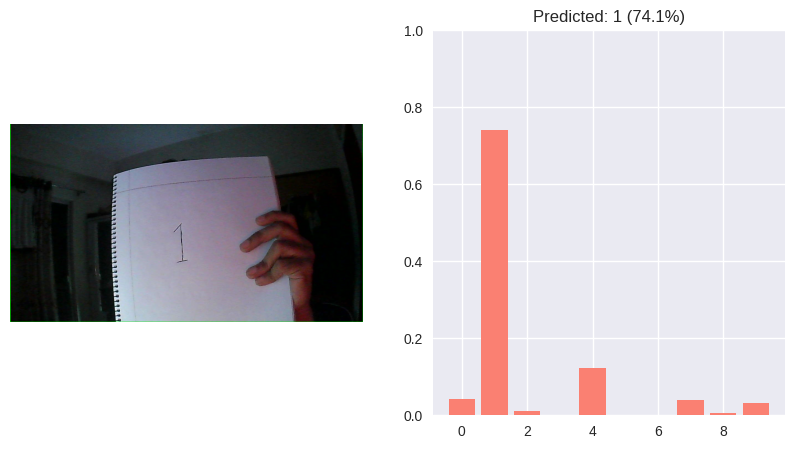

In [ ]:

def main():
    try:
        import google.colab
        print("Colab → use image demo"); colab_image_demo()
    except ImportError:
        print("Local → start camera"); run_camera_demo()

main()